In [1]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

from biobank_olink.constants import PROJECT_ROOT

In [2]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("prospective")]
results = pd.DataFrame(chain.from_iterable(results))

group_cols = ["lifestyle", "ext", "sbp", "dbp", "olink", "panel"]
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "best_trial_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(group_cols, dropna=False).agg(**agg_values, count=("model", 'size'))

mean_auc_score  \
lifestyle ext   sbp   dbp   olink panel                          
False     False False False False ALL                 0.667863   
True      False False False False ALL                 0.706904   
          True  False False False ALL                 0.716399   
                            True  ALL                 0.739353   
                                  BP                  0.732320   
                                  ENDOTHELIAL         0.715940   
                                  IMMUNE              0.727439   
                                  IMMUNE_INFL2        0.721478   
                                  INFL2               0.718491   
                                  RENAL               0.727721   
                      True  False ALL                 0.727460   
                            True  ALL                 0.748643   
                True  False False ALL                 0.725141   
                            True  ALL                 0.751822   

                                                mean_best_trial_score  \
lifestyle ext   sbp   dbp   olink panel                                 
False     False False False False ALL                        0.671095   
True      False False False False ALL                        0.711587   
          True  False False False ALL                        0.716923   
                            True  ALL                        0.736216   
                                  BP                         0.733439   
                                  ENDOTHELIAL                0.713254   
                                  IMMUNE                     0.723735   
                                  IMMUNE_INFL2               0.722619   
                                  INFL2                      0.717785   
                                  RENAL                      0.729092   
                      True  False ALL                        0.728059   
                            True  ALL                        0.740613   
                True  False False ALL                        0.728335   
                            True  ALL                        0.744341   

                                                mean_num_trials  \
lifestyle ext   sbp   dbp   olink panel                           
False     False False False False ALL                     107.0   
True      False False False False ALL                     107.0   
          True  False False False ALL                     107.0   
                            True  ALL                     107.0   
                                  BP                      107.0   
                                  ENDOTHELIAL             114.4   
                                  IMMUNE                  107.0   
                                  IMMUNE_INFL2            107.0   
                                  INFL2                   107.0   
                                  RENAL                   107.0   
                      True  False ALL                     114.8   
                            True  ALL                     107.0   
                True  False False ALL                     123.0   
                            True  ALL                     107.0   

                                                mean_best_trial_no  \
lifestyle ext   sbp   dbp   olink panel                              
False     False False False False ALL                         68.8   
True      False False False False ALL                         77.0   
          True  False False False ALL                         85.4   
                            True  ALL                         86.0   
                                  BP                          82.4   
                                  ENDOTHELIAL                 79.2   
                                  IMMUNE                      53.2   
                                  IMMUNE_INFL2                79.0   
                                  INFL2          

In [3]:
results_gb = results.groupby(group_cols, as_index=False)
results_aucs = results_gb.agg({"auc_score": "mean", "x_shape": lambda v: v.values[0][1]})
results_aucs["exp_case"] = "age+sex"
results_aucs["exp_case"] += results_aucs[group_cols[:-2]].apply(
    lambda row: "".join(f"+{v}" for v in row.index[row]), axis=1
)
results_aucs["exp_case"] += (
    results_aucs
    .panel
    .apply(lambda v: f"+{v}")
    .where(results_aucs.olink, "")
    .str.lower()
)
results_aucs = results_aucs.set_index(["exp_case", "x_shape"])["auc_score"]
results_aucs.sort_index(level=1, inplace=True)
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs.index.name = "exp_case"
results_aucs

exp_case
age+sex (2)                                 0.667863
age+sex+lifestyle (18)                      0.706904
age+sex+lifestyle+ext (35)                  0.716399
age+sex+lifestyle+ext+dbp (36)              0.727460
age+sex+lifestyle+ext+sbp (36)              0.725141
age+sex+lifestyle+ext+bp (219)              0.732320
age+sex+lifestyle+ext+endothelial (237)     0.715940
age+sex+lifestyle+ext+renal (348)           0.727721
age+sex+lifestyle+ext+infl2 (539)           0.718491
age+sex+lifestyle+ext+immune (924)          0.727439
age+sex+lifestyle+ext+immune_infl2 (988)    0.721478
age+sex+lifestyle+ext+all (2750)            0.739353
age+sex+lifestyle+ext+dbp+all (2751)        0.748643
age+sex+lifestyle+ext+sbp+all (2751)        0.751822
Name: auc_score, dtype: float64

Text(0.5, 1.0, 'I10 diagnosis within 10 years, 5-fold AUC, 15.7k patients [6% I10]')

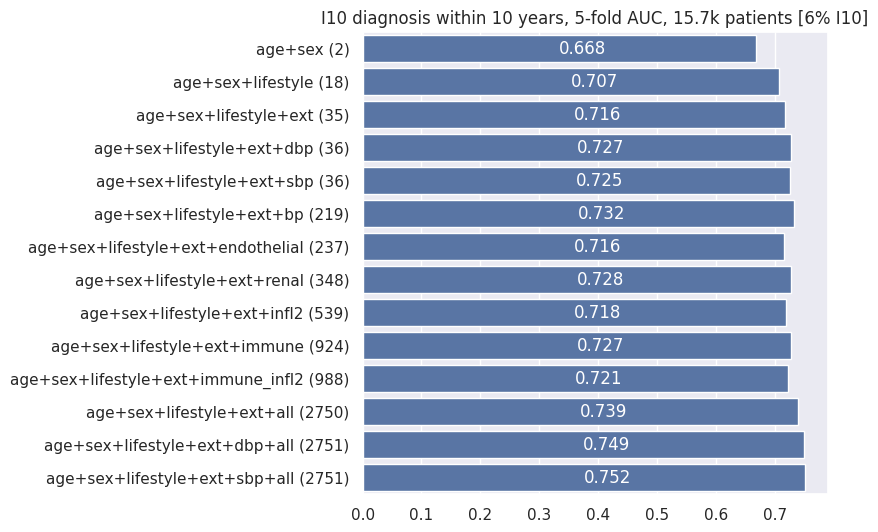

In [4]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=results_aucs.reset_index(), y="exp_case", x="auc_score")
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width / 2,
        p.get_y() + p.get_height() / 2,
        '{:.3f}'.format(width),
        va='center', color="white"
    )
plt.ylabel(None)
plt.xlabel(None)
plt.title("I10 diagnosis within 10 years, 5-fold AUC, 15.7k patients [6% I10]")